<a href="https://colab.research.google.com/github/raheeltahir55/CE888/blob/main/Project/Proj_MultiEval_Offensive_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#### OFFENSIVE ####
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import io
import requests
from sklearn.metrics import f1_score
import zipfile

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import SpatialDropout1D
import tensorflow as tf
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import Dropout
import keras
from keras.models import load_model

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
r= requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt', allow_redirects= True)
open('train_text.txt', 'wb').write(r.content)
example1 = "/content/train_text.txt"
with open(example1, "r") as file1:
    data = file1.readlines()

In [5]:
r= requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt', allow_redirects= True)
open('train_labels.txt', 'wb').write(r.content)
example1 = "/content/train_labels.txt"
with open(example1, "r") as file1:
    data1 = file1.readlines()

In [6]:
r= requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt', allow_redirects= True)
open('test_text.txt', 'wb').write(r.content)
example1 = "/content/test_text.txt"
with open(example1, "r") as file1:
    data2 = file1.readlines()

In [7]:
r= requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt', allow_redirects= True)
open('test_labels.txt', 'wb').write(r.content)
example1 = "/content/test_labels.txt"
with open(example1, "r") as file1:
    data3 = file1.readlines()

In [8]:
data= [data[i].strip() for i in range(len(data))]
data1= [data1[i].strip() for i in range(len(data1))]
data2= [data2[i].strip() for i in range(len(data2))]
data3= [data3[i].strip() for i in range(len(data3))]

In [9]:
### df is dataframe for training data

df= pd.DataFrame()
for index in range(len(data)):
  df.loc[index, 'Text']=data[index]
for index in range(len(data1)):
  df.loc[index, 'Label']=data1[index]
df.head()

,Text,Label
0,@user Bono... who cares. Soon people will unde...,0
1,@user Eight years the republicans denied obama...,1
2,@user Get him some line help. He is gonna be j...,0
3,@user @user She is great. Hi Fiona!,0
4,@user She has become a parody unto herself? Sh...,1


In [10]:
### df1 is dataframe for test data

df1= pd.DataFrame()
for index in range(len(data2)):
  df1.loc[index, 'Text']=data2[index]
for index in range(len(data3)):
  df1.loc[index, 'Label']=data3[index]
df1.head()

,Text,Label
0,#ibelieveblaseyford is liar she is fat ugly li...,1
1,@user @user @user I got in a pretty deep debat...,0
2,"...if you want more shootings and more death, ...",0
3,Angels now have 6 runs. Five of them have come...,0
4,#Travel #Movies and Unix #Fortune combined Vi...,0


In [11]:
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [12]:
Text_Train= []
Text_Final= []
# Step - a : Remove blank rows if any.
df.dropna(inplace=True)

# Step - b : Change all the text to lower case.
df['Text'] = [entry.lower() for entry in df['Text']]

# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
df['Text']= [word_tokenize(entry) for entry in df['Text']]

for index,entry in enumerate(df['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'Text_Final'
    df.loc[index,'Text_Final'] = str(Final_words) 
    Text_Train.append(Final_words)
    Text_Final.append(Final_words)

In [13]:
Text_Test= []
# Step - a : Remove blank rows if any.
df1.dropna(inplace=True)

# Step - b : Change all the text to lower case.
df1['Text'] = [entry.lower() for entry in df1['Text']]

# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
df1['Text']= [word_tokenize(entry) for entry in df1['Text']]

for index,entry in enumerate(df1['Text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'Text_Final'
    df1.loc[index,'Text_Final'] = str(Final_words) 
    Text_Test.append(Final_words)

In [14]:
Text_Final.extend(Text_Test)
print(len(Text_Final))

12776


In [15]:
t_df= pd.concat([df, df1])
t_df['Label'].value_counts()

0    8595
1    4181
Name: Label, dtype: int64

In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 16000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 20
# Embedding Dimension
EMBEDDING_DIM = 300

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(Text_Final)
word_index = tokenizer.word_index

In [17]:
print('Found %s unique tokens.' % len(word_index))

Found 15293 unique tokens.


In [18]:
print(word_index)

{'user': 1, 'liberal': 2, 'gun': 3, 'control': 4, 'antifa': 5, 'like': 6, 'get': 7, 'conservative': 8, 'maga': 9, 'people': 10, 'go': 11, 'say': 12, 'know': 13, 'think': 14, 'one': 15, 'make': 16, 'good': 17, 'trump': 18, 'amp': 19, 'u': 20, 'want': 21, 'right': 22, 'would': 23, 'need': 24, 'see': 25, 'time': 26, 'look': 27, 'take': 28, 'love': 29, 'try': 30, 'shit': 31, 'woman': 32, 'never': 33, 'vote': 34, 'work': 35, 'democrat': 36, 'law': 37, 'call': 38, 'way': 39, 'come': 40, 'well': 41, 'back': 42, 'thing': 43, 'use': 44, 'even': 45, 'year': 46, 'give': 47, 'really': 48, 'support': 49, 'lie': 50, 'tell': 51, 'still': 52, 'believe': 53, 'fuck': 54, 'much': 55, 'keep': 56, 'let': 57, 'talk': 58, 'party': 59, 'show': 60, 'man': 61, 'great': 62, 'president': 63, 'also': 64, 'kavanaugh': 65, 'country': 66, 'bad': 67, 'care': 68, 'life': 69, 'stop': 70, 'help': 71, 'mean': 72, 'many': 73, 'hope': 74, 'another': 75, 'could': 76, 'nothing': 77, 'day': 78, 'always': 79, 'please': 80, 'new

In [19]:
df.head()

,Text,Label,Text_Final
0,"[@, user, bono, ..., who, cares, ., soon, peop...",0,"['user', 'bono', 'care', 'soon', 'people', 'un..."
1,"[@, user, eight, years, the, republicans, deni...",1,"['user', 'eight', 'year', 'republican', 'deny'..."
2,"[@, user, get, him, some, line, help, ., he, i...",0,"['user', 'get', 'line', 'help', 'gon', 'na', '..."
3,"[@, user, @, user, she, is, great, ., hi, fion...",0,"['user', 'user', 'great', 'hi', 'fiona']"
4,"[@, user, she, has, become, a, parody, unto, h...",1,"['user', 'become', 'parody', 'unto', 'certainl..."


In [20]:
df1.head()

,Text,Label,Text_Final
0,"[#, ibelieveblaseyford, is, liar, she, is, fat...",1,"['ibelieveblaseyford', 'liar', 'fat', 'ugly', ..."
1,"[@, user, @, user, @, user, i, got, in, a, pre...",0,"['user', 'user', 'user', 'get', 'pretty', 'dee..."
2,"[..., if, you, want, more, shootings, and, mor...",0,"['want', 'shooting', 'death', 'listen', 'aclu'..."
3,"[angels, now, have, 6, runs, ., five, of, them...",0,"['angel', 'run', 'five', 'come', 'courtesy', '..."
4,"[#, travel, #, movies, and, unix, #, fortune, ...",0,"['travel', 'movie', 'unix', 'fortune', 'combin..."


In [21]:
X_train = tokenizer.texts_to_sequences(Text_Train)
X_test = tokenizer.texts_to_sequences(Text_Test)

In [22]:
X_train[3], X_train[1], X_test[1], X_test[3]

([1, 1, 62, 1009, 2889],
 [1, 2532, 46, 118, 1053, 170, 392, 7030, 874, 1784, 177, 63],
 [1,
  1,
  1,
  7,
  230,
  445,
  590,
  190,
  51,
  14149,
  18,
  125,
  18,
  108,
  200,
  12,
  72,
  5,
  108,
  962,
  267,
  12,
  12,
  303,
  183],
 [1487,
  128,
  1928,
  40,
  4218,
  1706,
  6925,
  4692,
  6925,
  5382,
  2446,
  6596,
  453,
  1472])

In [23]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [24]:
X_train= np.array(X_train)
X_test= np.array(X_test)
print('Shape of data tensor:', X_train.shape)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (11916, 20)
Shape of data tensor: (860, 20)


In [25]:
X_train[1,:], X_test[1,:]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    1, 2532,   46,
         118, 1053,  170,  392, 7030,  874, 1784,  177,   63], dtype=int32),
 array([  445,   590,   190,    51, 14149,    18,   125,    18,   108,
          200,    12,    72,     5,   108,   962,   267,    12,    12,
          303,   183], dtype=int32))

In [26]:
X_train[:,3], X_test[:,3]

(array([  68,    0,  300, ...,    0,    0, 3823], dtype=int32),
 array([    0,    51,   237,     0,  4487,     0,     0, 14157,     0,
          677,  1868,     0,  1300,     0,     0,     0,     0,     0,
            0,  3310, 14177,   671,     0,     0,    18,     0,     0,
            0,  3079,  1374,     0,     1,  6787,     0, 14193,     8,
          223,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,   464,   162,     0,   512,     0, 14210,     0,
            0,     0, 14215,     0,     0,     0,     0,     0,    36,
            0,   773,  2875,     0,     0,     0,     4,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
          429,     0,     0,  2265,     0,     0,     0,     0,  1506,
            0,     0,     0,     0,     0,     0,     0,   514,     0,
            0, 14265,     0,   967,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   379,     0,    13,
            0

In [27]:
y_train= df['Label'].values
y_test= df1['Label'].values

In [28]:
y_train= y_train.astype(np.int32)
y_test= y_test.astype(np.int32)

In [29]:
print(y_train[20:25])

[0 1 0 1 1]


In [30]:
print(y_train[0:10])

[0 1 0 0 1 0 1 0 0 0]


In [31]:
url= "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r=requests.get(url)
z=zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [32]:
## FastText
import codecs
embeddings_index = {}
f=codecs.open('./wiki-news-300d-1M.vec', encoding= 'utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 999995 word vectors.


In [33]:
vocab_size= MAX_NB_WORDS
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
words_not_found= []
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None: 
    embedding_matrix[i] = embedding_vector
  else:
    words_not_found.append(word)

In [34]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

In [35]:
print(embedding_matrix[1:2,:])

[[ 0.0793      0.0079      0.0555     -0.0205      0.0599     -0.0173
  -0.0016      0.0223      0.0595     -0.0254     -0.0138     -0.1036
   0.0826      0.1204      0.0047     -0.0539     -0.0558      0.27970001
  -0.0729      0.0893     -0.18610001 -0.2061      0.15899999  0.0328
  -0.0833     -0.0096     -0.0399     -0.0598     -0.1119     -0.0052
  -0.0543      0.0368      0.0578     -0.0288      0.0152      0.16
   0.1459      0.0465     -0.1142     -0.0805      0.1349      0.0502
   0.0654     -0.0773     -0.1373     -0.21269999 -0.0183     -0.048
   0.0552      0.0953     -0.0552      0.0823     -0.6591      0.1621
   0.21070001  0.0116     -0.022      -0.0585     -0.0517      0.0312
   0.14929999  0.021      -0.1256      0.0572      0.0276     -0.0512
  -0.0944     -0.0964     -0.0221     -0.0047     -0.0039      0.1116
  -0.0239      0.1679      0.0164     -0.1096     -0.0972      0.0773
   0.0245      0.13869999  0.0412      0.0705      0.036      -0.175
   0.0887     -0.105

In [36]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
# x = Conv1D(32, 5, activation='relu')(embedding_sequences)
x = Bidirectional(LSTM(32, dropout= 0.5, recurrent_dropout= 0.5))(embedding_sequences)
x = Dropout(0.5)(x)
x = Dense(20, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 300)           4800000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 4,886,569
Trainable params: 86,569
Non-trainable params: 4,800,000
______________________________________________

In [39]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

LR = 1e-3

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [40]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [41]:
BATCH_SIZE = 128
EPOCHS = 50

In [42]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                   validation_data= (X_test,y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/50
94/94 [==============================] - 21s 147ms/step - loss: 0.6327 - accuracy: 0.6637 - val_loss: 0.5073 - val_accuracy: 0.7640
Epoch 2/50
94/94 [==============================] - 13s 139ms/step - loss: 0.5377 - accuracy: 0.7379 - val_loss: 0.4203 - val_accuracy: 0.8047
Epoch 3/50
94/94 [==============================] - 13s 138ms/step - loss: 0.4971 - accuracy: 0.7616 - val_loss: 0.4139 - val_accuracy: 0.8070
Epoch 4/50
94/94 [==============================] - 13s 139ms/step - loss: 0.4850 - accuracy: 0.7751 - val_loss: 0.4171 - val_accuracy: 0.8023
Epoch 5/50
94/94 [==============================] - 13s 135ms/step - loss: 0.4849 - accuracy: 0.7683 - val_loss: 0.4039 - val_accuracy: 0.8174
Epoch 6/50
94/94 [==============================] - 13s 143ms/step - loss: 0.4764 - accuracy: 0.7797 - val_loss: 0.4070 - val_accuracy: 0.8174
Epoch 7/50
94/94 [==============================] - 13s 139ms/step - loss: 0.4635 - accuracy: 0.7890 - val_loss: 0.4240 - val_accuracy: 0.8174

In [43]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

27/27 [==============================] - 0s 12ms/step - loss: 0.4140 - accuracy: 0.8186
Test set
  Loss: 0.414
  Accuracy: 0.819


In [44]:
y_pred = model.predict(X_test)

In [45]:
print(y_pred[0:10])

[[0.96940595]
 [0.70669705]
 [0.15909639]
 [0.00696983]
 [0.10734679]
 [0.00788406]
 [0.08339414]
 [0.0065381 ]
 [0.8086968 ]
 [0.40604275]]


In [46]:
y_pred = y_pred > 0.5

In [ ]:
print("F1 Score -> ",f1_score(y_pred, y_test, average='macro')*100)

F1 Score ->  76.73327186293942


In [ ]:
model.save('multieval_offensive_lstm.h5')

In [ ]:
# model = load_model('../input/offensive-lstm/multieval_offensive_lstm.h5')

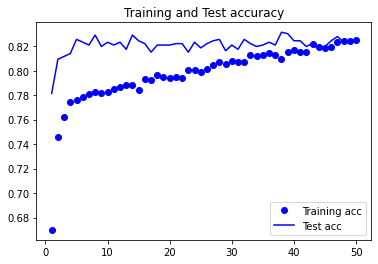

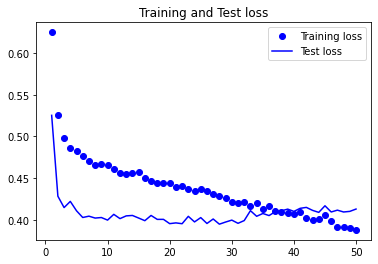

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Test acc')
plt.title('Training and Test accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.legend()
